# BERTopic Short Demo

If you are working on Colab, 
- The following cell installs all the packages you will need. 
- You may want to make use of the (free) GPU resources: click on the down arrow in the upper-right of the page next to the RAM and Disk usage graphic.  Then "Change runtime type" and select "T4 GPU".  This will dramatically speed up your runtime for this code.
- Please be sure to save your file on your own account. (If you clicked on the link on our GitHub repo, your changes are not saved automatically).

If you are working locally on your computer, please see the [README.md](https://github.com/nuitrcs/AI_Week_Topic_Model/blob/main/README.md) file on our GitHub repo for a command to create a conda environment that has the necessary packages.

In [1]:
try:
    import google.colab
    print("You are working in Google Colab.  We will install necessary packages...")
    !pip install scikit-learn sentence-transformers umap-learn hdbscan bertopic pandas matplotlib datashader bokeh holoviews scikit-image colorcet keybert
except:
    print("You are not working in Google Colab.")
    print("Please be sure that the necessary packages are installed and available, ideally within a conda env (e.g., see here: https://github.com/nuitrcs/AI_Week_Topic_Model/blob/main/README.md).")


You are not working in Google Colab.
Please be sure that the necessary packages are installed and available, ideally within a conda env (e.g., see here: https://github.com/nuitrcs/AI_Week_Topic_Model/blob/main/README.md).


### Read in the Preprocessed Data

For this demo, we will use the [`20newsgroups` dataset from scikit-learn](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset).  We will fetch the data and then clean reformat it so that it is easier for BERTopic to work with.  I wrote code to do this in the `exercises/supplementary_code.ipynb` notebook; that code also saves the output to a .csv file.  We can simply read in the resulting cleaned data below.  

In [2]:
import pandas as pd
# The line below will read the file directly from GitHub and will work on Colab.  
df = pd.read_csv('https://raw.githubusercontent.com/nuitrcs/AI_Week_Topic_Modeling/refs/heads/main/exercises/data/sklearn_20newsgroups_cleaned.csv')
# If you're working on your local computer and prefer to simply read the file from your disk, you can instead use the line below.
# df = pd.read_csv('exercises/data/sklearn_20newsgroups_cleaned.csv')
df.head()

,original_text,cleaned_text,labels,labels_text
0,\nCONGRAULATIONS !!!! Your helmet just passed ...,CONGRAULATIONS !!!! Your helmet just passed th...,2,rec.motorcycles
1,SP> From: paulson@tab00.larc.nasa.gov (Sharon ...,SP> From: paulson@tab00.larc.nasa.gov (Sharon ...,6,sci.med
2,"Dear Binary Newsers,\n\nI am looking for Quick...","Dear Binary Newsers,\n\nI am looking for Quick...",0,comp.graphics
3,"Thanks to aldridge@netcom.com, I now know a bi...","Thanks to aldridge@netcom.com, I now know a bi...",6,sci.med
4,Are there significant differences between V2.0...,Are there significant differences between V2.0...,0,comp.graphics


In [3]:
# store the texts into docs variable as a list for use in BERTopic
docs = df["cleaned_text"].values.tolist()
print(docs[:5])

['CONGRAULATIONS !!!! Your helmet just passed the Snell Test.\n \n\nOh well, as least it looks ok now. Still, it may not save your head as well\nas before you dropped it.\n\nMike', "SP> From: paulson@tab00.larc.nasa.gov (Sharon Paulson)\nSP> to describe here.  I have a fourteen year old daugter who experienced\nSP> a seizure on November 3, 1992 at 6:45AM after eating Kellog's Frosted\nSP> Flakes.\n\nSP> Well, we were going along fine and the other morning, April 5, she had\nSP> a bowl of another Kellog's frosted kind of cereal, Fruit Loops (I am\n\nSP> When I mentioned what she ate the first time as a possible reason for\nSP> the seizure the neurologist basically negated that as an idea.  Now\nSP> after this second episode, so similar in nature to the first, even\nSP> he is scratching his head.\n\nThere's no data that sugar-coated cereals cause seizures.  I haven't\neven seen anything anecdotal on it.  Given how common they are eaten\n- do you know any child or adolescent who *doesn't*

### Simplest case

BERTopic can be run out of the box without any tuning. However, this doesn't guarantee the best number of topics and representation for each topic.

In [4]:
from bertopic import BERTopic

topic_model = BERTopic() # initialize the model
topic_model.fit(docs) # fit the model to the data

topic_model.get_topic_info() # get the topic information

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1463,-1_the_to_of_and,"[the, to, of, and, is, in, for, it, you, that]","[Howdy,\n\nI'm a little new to this newsgroup,..."
1,0,485,0_the_team_he_hockey,"[the, team, he, hockey, 550, play, 25, in, gam...",[The FLYERS closed out the season last night w...
2,1,463,1_he_his_the_year,"[he, his, the, year, in, that, and, to, was, but]",[So far Simmons looks like a total idiot.\n\n\...
3,2,106,2_car_cars_the_it,"[car, cars, the, it, they, you, that, and, eng...",[My whole point was not to say that the cars *...
4,3,92,3_chip_pin_chips_them,"[chip, pin, chips, them, to, latch, have, mhz,...",[For an upcoming project I want to use 4 Megs ...
...,...,...,...,...,...
68,67,11,67_cview_temp_file_files,"[cview, temp, file, files, floppy, disk, direc...",[: >over where it places its temp files: it ju...
69,68,11,68_42_question_answer_alice,"[42, question, answer, alice, universe, discov...","[-> According to the TIFF 5.0 Specification, t..."
70,69,11,69_taste_food_sticks_crullerian,"[taste, food, sticks, crullerian, crullers, re...","[Wasn't there a ""plain"" flavor too? They look..."
71,70,10,70_moa_bmw_bmwmoa_election,"[moa, bmw, bmwmoa, election, politics, ra, ama...",[As a new BMW owner I was thinking about signi...


## Now let's break this down into the componet steps we discussed in the presentation:

![graphical representation of topic modeling pipeline](exercises/images/topic_modeling_pipeline.png)

1. Embeddings
2. Dimension reduction
3. Clustering
4. Labeling

Each of these steps have parameters we can tune.  This way we will have more fine-grained control so that we can improve the topics that are returned.

### 1. Embeddings

![graphical representation of embedding step](exercises/images/embeddings.png)


This step uses a language model to convert the text from the documents into vectors.

In [5]:
from sentence_transformers import SentenceTransformer

# initialize model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # all-MiniLM-L6-v2 is the name of a pretrained model
embeddings = embedding_model.encode(docs) # encode the texts into embeddings

In [6]:
print("Dimension of embeddings: ")
print(embeddings.shape)
print()
print(embeddings)

Dimension of embeddings: 
(4606, 384)

[[-0.00213906  0.04308944  0.05013816 ... -0.01613713 -0.02208866
   0.0770644 ]
 [-0.03420198 -0.08700935  0.02444814 ...  0.03278661 -0.0257326
   0.05272754]
 [-0.01358028 -0.02875866 -0.05647382 ...  0.0659287   0.00590128
  -0.01697433]
 ...
 [-0.06831518  0.04242566  0.02433797 ...  0.05475039 -0.03422439
   0.02065528]
 [-0.03812822 -0.02588739 -0.11860322 ...  0.07860988 -0.00089193
   0.04407001]
 [-0.02731515  0.05332449  0.06714314 ... -0.04175347 -0.09743451
   0.00926416]]


### 2. Dimension reduction

![graphical representation of dimension reduction step](exercises/images/dimension_reduction.png)


This step uses the [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) library to reduce the dimensions to 2 (to make it easier to cluster the data in the next step).

In [7]:
from umap import UMAP
import umap.plot

# set random seed for reproducibility
seed = 42
# initialize UMAP model
umap_model = UMAP(n_components=2, n_neighbors = 15, metric="cosine", random_state=seed)
# fit the UMAP model to find the best 2D representation of the embeddings
umap_model.fit(embeddings)

/home/ageller/miniforge3/envs/topic-modeling-wsl/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/home/ageller/miniforge3/envs/topic-modeling-wsl/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/home/ageller/miniforge3/envs/topic-modeling-wsl/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature



,n_neighbors,15
,n_components,2
,metric,'cosine'
,metric_kwds,None
,output_metric,'euclidean'
,output_metric_kwds,None
,n_epochs,None
,learning_rate,1.0
,init,'spectral'
,min_dist,0.1
,spread,1.0


In [8]:
print("Dimension of UMAP output: ")
print(umap_model.embedding_.shape)

Dimension of UMAP output: 
(4606, 2)


<Axes: >

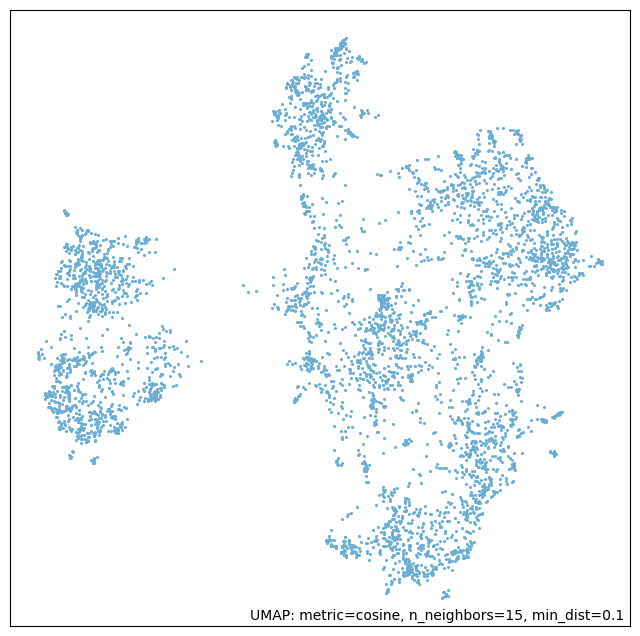

In [9]:
# Plot the UMAP representation
umap.plot.points(umap_model)

### 3. Clustering

![graphical representation of clustering step](exercises/images/clustering.png)


Here we use the [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/#) library, a suite of tools that uses unsupervised machine learning, to identify clusters in the data.  

Note that you may see different clusters than other participants working on different computers because of the way each computer handles randomization.  But (hopefully!) your notebook will be internally consistent if you rerun it with the same random seed.

<Axes: >

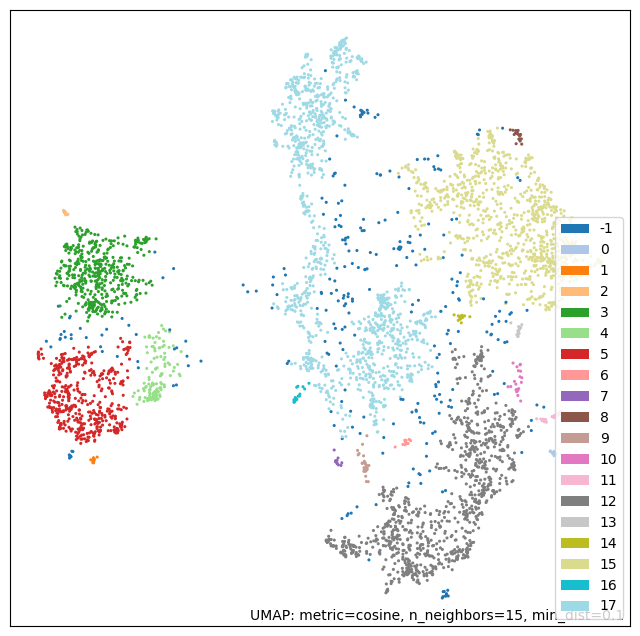

In [10]:
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# initialize HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=12, min_samples=5, cluster_selection_epsilon=0.2)

# identify clusters on the 2-d representation of embeddings generated by UMAP
hdbscan_model.fit(umap_model.embedding_)
umap.plot.points(umap_model, labels=hdbscan_model.labels_, theme="blue")

### 4. Labeling

![graphical representation of labeling step](exercises/images/labeling.png)

Here we label each cluster using another language model with [KeyBERT](https://maartengr.github.io/KeyBERT/api/keybert.html).  Note that this is similar to, though not identical, to what BERTopic uses (e.g., see the BERTopic documentation [here](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired)). 

In [11]:
from keybert import KeyBERT
import numpy as np

# initialize the model; can use the same LM as we used for embeddings
rep_model = KeyBERT(model='all-MiniLM-L6-v2')

hlabels = []
counts = []
words = []
# loop through the clusters and get the labels (as BERTopic would do)
for label in np.unique(hdbscan_model.labels_):
    # Get docs in this cluster
    cluster_docs = [doc for doc, c in zip(docs, hdbscan_model.labels_) if c == label]
    # Combine documents into a single string
    combined_text = ' '.join(cluster_docs)
    # Extract keywords
    keywords = rep_model.extract_keywords(combined_text, top_n=5)
    # save the results 
    # Note: KeyBERT returns a tuple with the (word, numer), where the number is:
    #   the relevance score, i.e., the cosine similarity between the embedding of the keyword and the original doc
    hlabels.append(label)
    counts.append(len(cluster_docs))
    words.append([kw[0] for kw in keywords])

# save this in a dataframe so it is prettier to look at (and easier to sort)
output_df = pd.DataFrame({'hdbscan_label':hlabels, 'count':counts, 'keywords':words})
# sort by counts (easier to compare to BERTopic output)
output_df.sort_values(by="count", ascending=False)

,hdbscan_label,count,keywords
18,17,1191,"[seizures, cereal, cereals, seizure, epilepsy]"
16,15,954,"[500cc, k100rs, 750cc, 400s, kz1000]"
13,12,938,"[radiosity_code, photodiode, decoder, image32,..."
6,5,454,"[mets, jerseys, uniforms, reds, phillies]"
4,3,447,"[pitches, pitching, inning, hitters, innings]"
0,-1,291,"[wrights, wright, wilbur, beamers, architectures]"
5,4,123,"[nbc, espn, sportschannel, cbs, televised]"
12,11,29,"[telephone, caller, dial, calling, handset]"
10,9,24,"[archives, archive, archiving, digitised, phot..."
9,8,21,"[helmet, helmetted, helmeted, helmets, dropped]"


## Combine All Steps with BERTopic

In [12]:
from bertopic.representation import KeyBERTInspired

# set random seed for reproducibility
seed = 42

# embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # all-MiniLM-L6-v2 is name of pretrained model

# umap model
umap_model = UMAP(n_components=2, n_neighbors = 15, metric="cosine", random_state=seed)

# initialize HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=12, min_samples=5, cluster_selection_epsilon=0.2)

# representation model
representation_model = KeyBERTInspired()

# define the BERTopic model using the models above
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    verbose=True
)

# fit the model to the data
topic_model.fit(docs) 

# get the topic information
topic_model.get_topic_info() 

2025-08-15 12:33:27,682 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/144 [00:00<?, ?it/s]

2025-08-15 12:33:34,813 - BERTopic - Embedding - Completed ✓
2025-08-15 12:33:34,813 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-15 12:33:38,257 - BERTopic - Dimensionality - Completed ✓
2025-08-15 12:33:38,258 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-15 12:33:38,298 - BERTopic - Cluster - Completed ✓
2025-08-15 12:33:38,300 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-08-15 12:33:39,410 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,291,-1_dod_keyboard_re_new,"[dod, keyboard, re, new, mail, use, what, for,...",[Archive-name: typing-injury-faq/keyboards\nVe...
1,0,1191,0_medical_research_health_science,"[medical, research, health, science, nasa, not...","[Gee! Maybe I've misjudged you, Russell. Any..."
2,1,954,1_ride_bike_car_road,"[ride, bike, car, road, cars, miles, drive, ab...","[Howdy,\n\nI'm a little new to this newsgroup,..."
3,2,938,2_graphics_software_jpeg_program,"[graphics, software, jpeg, program, files, ima...",[: My next project is to come up with an IF/de...
4,3,454,3_nhl_flyers_puck_hockey,"[nhl, flyers, puck, hockey, leafs, rangers, le...",[The FLYERS closed out the season last night w...
5,4,447,4_hitter_pitcher_pitching_braves,"[hitter, pitcher, pitching, braves, cubs, sox,...","[Oh, yeah. Dave Winfield--marginal player. G..."
6,5,123,5_espn_hockey_playoffs_station,"[espn, hockey, playoffs, station, abc, radio, ...","[Yes, a point well-taken ... however, even in ..."
7,6,29,6_telephone_dial_call_phone,"[telephone, dial, call, phone, telco, line, li...",[AL>> Question: Is there a certain de...
8,7,24,7_archive_images_files_nasa,"[archive, images, files, nasa, image, maps, fo...",[-------------------------------------\n\t+ .....
9,8,21,8_helmet_helmets_impact_fiberglass,"[helmet, helmets, impact, fiberglass, damage, ...",[This is not good advice. A couple of years I...
